In [1]:
from discriminator.dis import Dis
from cascade.model import CascadeNet
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils import data
from utils import *
from mri_utils import *
import os
import torchvision
from skimage.measure import compare_ssim as ssim

In [2]:
# %matplotlib qt
G = CascadeNet().cuda() # input channels:  Z(X) x Y -> output channel X

In [3]:
x = torch.load('../data/x.pt')

In [4]:
idx =1999
G.load_state_dict(torch.load('./parameters/checkpoint%d/G.pt'%(idx)))

In [5]:
def uncertainty_freq(y1, mask, title1, title2):    
    fs = []
    for i in range(10):
        zv = torch.rand((1, 2, 256, 256)).cuda()
        observedv = y1.cuda()
        inpv = torch.cat((observedv, zv), 1)
        fs.append(torch.fft(to5d(G(inpv, torch.unsqueeze(mask, 0).cuda()).cpu().detach()), signal_ndim = 2,normalized=True))

    fs = torch.cat(fs, 0)
    f_var = torch.var(fs, 0)
    f_var = f_var[0,:,:,0] +  f_var[0,:,:,1]
    # f_std = torch.sqrt(f_var)

    f_predict = torch.mean(fs, 0, keepdim=True)
    f_mean = tensor_abs(f_predict)[0,0,:,:]
    fy = tensor_abs(torch.fft(to5d(y1), signal_ndim = 2, normalized=True))[0,0]

    plt.figure(figsize=(20,5))
#     plt.subplot(211)
#     plt.title(title1,fontsize=15)
#     plt.bar(np.arange(256), torch.sum(fy, 1)>0.01,color='b')
#     plt.subplot(212)
    plt.title(title2,fontsize=15)
    plt.bar(np.arange(256), torch.sum(f_var, 1),color='r')
    f_var1 = f_var
    plt.ylim([0,0.35])
    return torch.sum(f_var, 1)

In [6]:
def uncer_diff(un1, un2, mask1, mask2):
    mask1 = mask1[:,0]
    mask2 = mask2[:,0]
    mask_diff = torch.abs(mask1-mask2)
    un_diff = un2 - un1
    plt.figure(figsize=(20,5))
    plt.bar(np.arange(256), un_diff, color='r')
    un_diff_mask = un_diff * mask_diff
    plt.bar(np.arange(256), un_diff_mask, color='b')

In [7]:
ind = torch.load('../data/uncertainty_descent/mask_idx.pt')

In [9]:
mask1 = torch.zeros((256,256))
mask2 = torch.zeros((256,256))

In [10]:
mask1[ind[:27],:]=1
mask2[ind[:28],:]=1

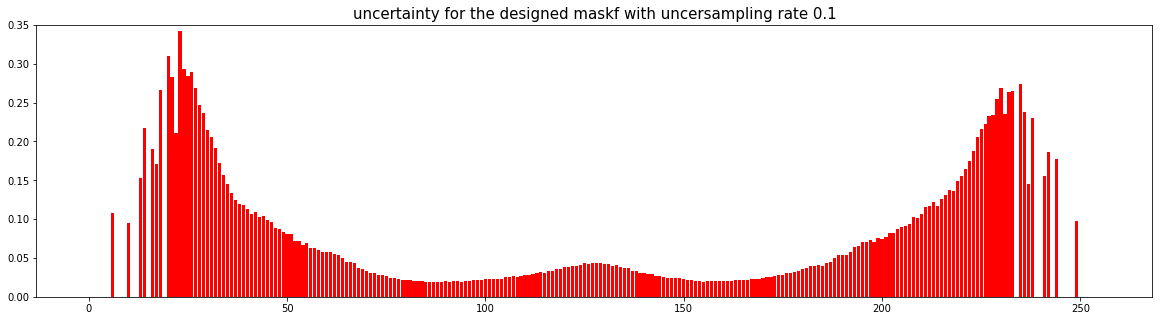

In [12]:
y1 = backward_op(forward_op(to5d(x),mask1))
un1 = uncertainty_freq(y1, mask1,'designed mask with undersampling rate 0.1', 'uncertainty for the designed maskf with uncersampling rate 0.1')

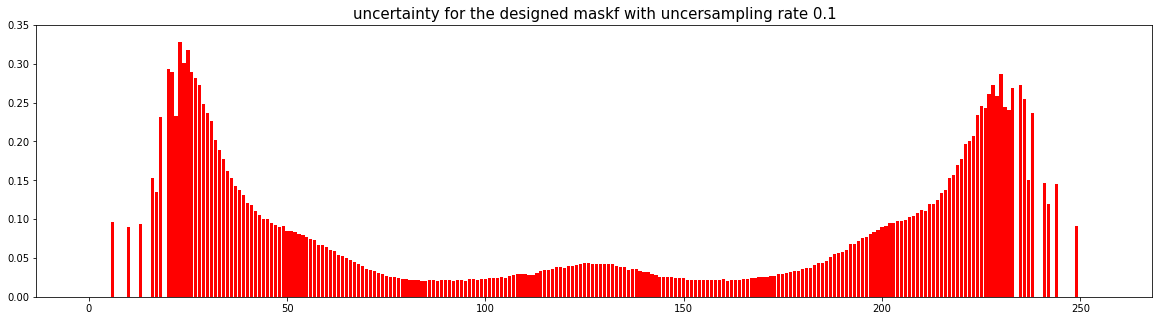

In [13]:
y2 = backward_op(forward_op(to5d(x),mask2))
un2 = uncertainty_freq(y2, mask2,'designed mask with undersampling rate 0.1', 'uncertainty for the designed maskf with uncersampling rate 0.1')

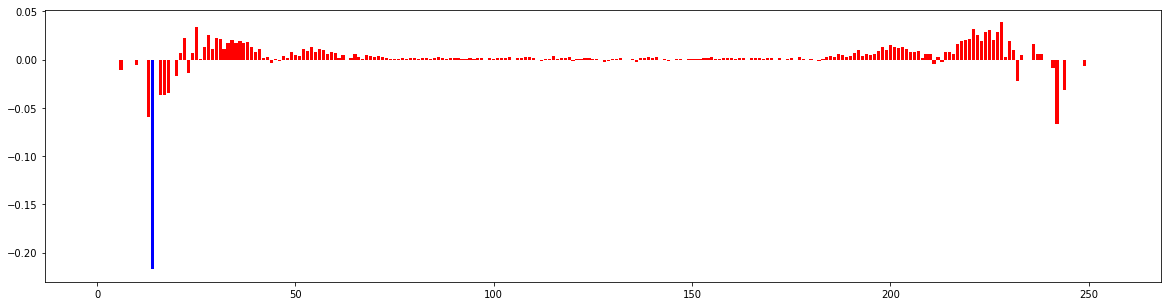

In [14]:
uncer_diff(un1, un2, mask1, mask2)

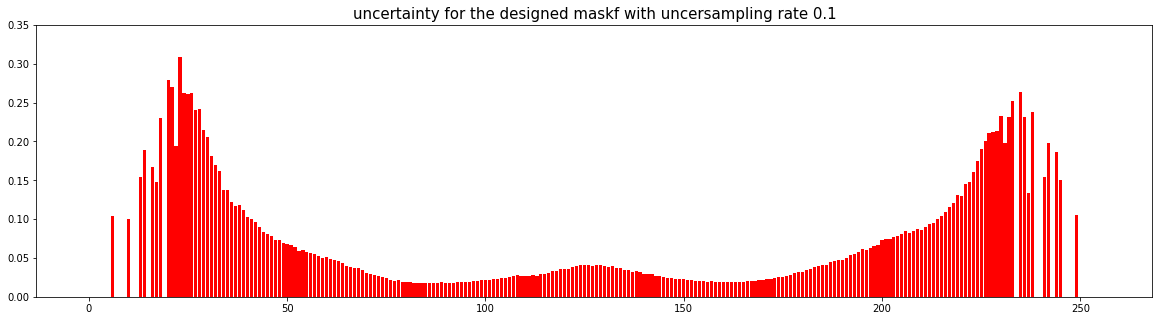

In [55]:
mask10 = torch.load('../data/uncertainty_descent/mask_10.pt')
y10 = backward_op(forward_op(to5d(x),mask10))
un10 = uncertainty_freq(y10, mask10,'designed mask with undersampling rate 0.1', 'uncertainty for the designed maskf with uncersampling rate 0.1')
plt.savefig('./results/uncer_change1.pdf')

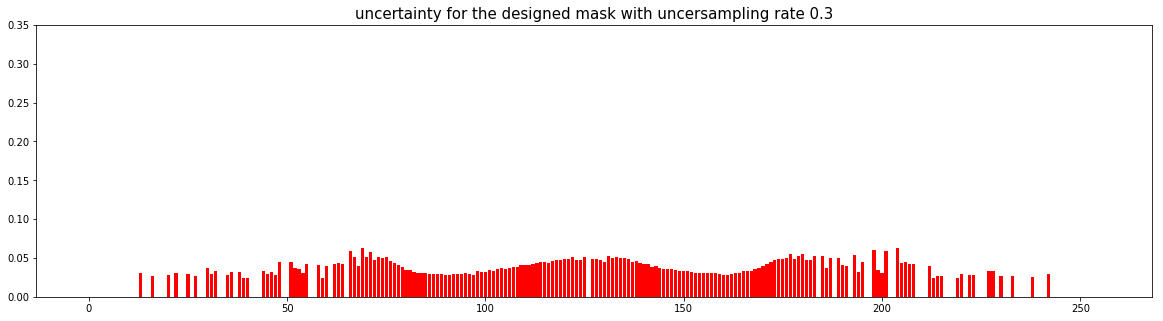

In [56]:
mask30 = torch.load('../data/uncertainty_descent/mask_30.pt')
y30 = backward_op(forward_op(to5d(x),mask30))
un30 = uncertainty_freq(y30, mask30,'designed mask with undersampling rate 0.3', 'uncertainty for the designed mask with uncersampling rate 0.3')
plt.savefig('./results/uncer_change2.pdf')

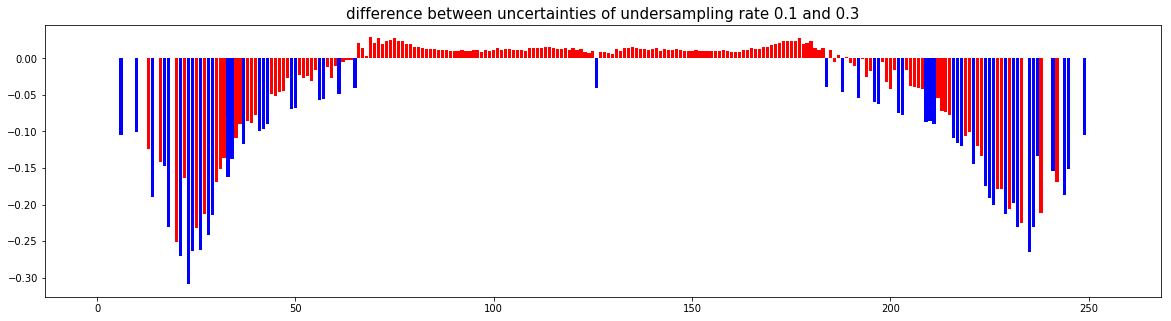

In [58]:
uncer_diff(un10, un30, mask10, mask30)
plt.title('difference between uncertainties of undersampling rate 0.1 and 0.3',fontsize=15)
plt.savefig('./results/uncer_change4.pdf')

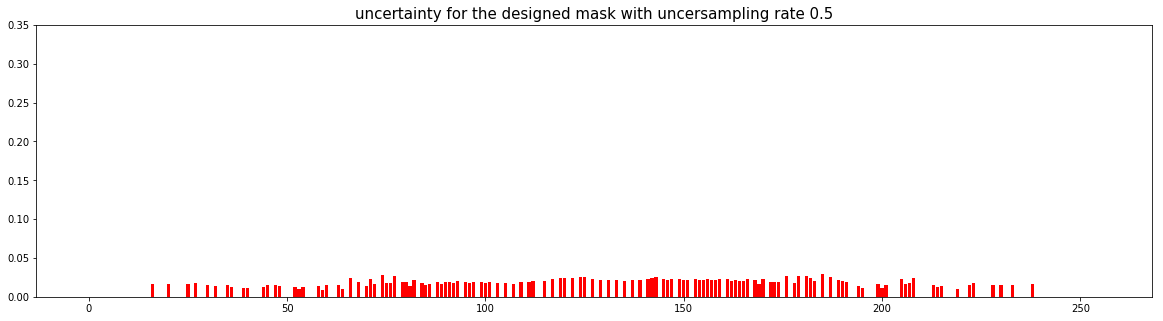

In [57]:
mask50 = torch.load('../data/uncertainty_descent/mask_50.pt')
y50 = backward_op(forward_op(to5d(x),mask50))
un50 = uncertainty_freq(y50, mask50,'designed mask with undersampling rate 0.5', 'uncertainty for the designed mask with uncersampling rate 0.5')
plt.savefig('./results/uncer_change3.pdf')

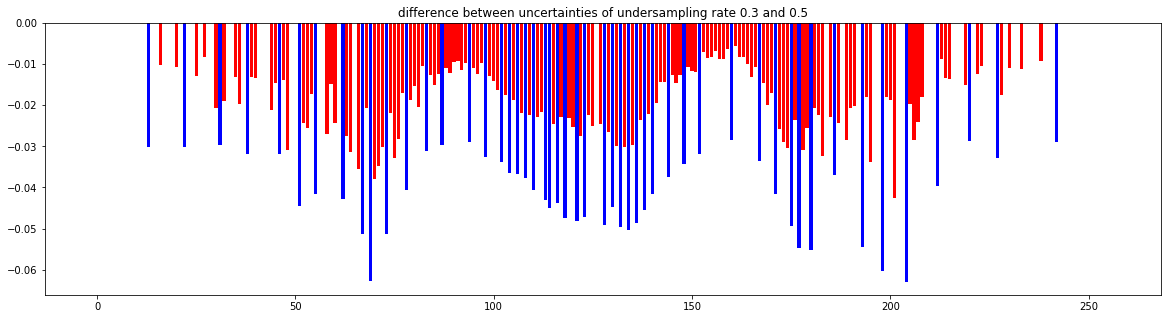

In [59]:
uncer_diff(un30, un50, mask30, mask50)
plt.title('difference between uncertainties of undersampling rate 0.3 and 0.5')
plt.savefig('./results/uncer_change5.pdf')